<a href="https://colab.research.google.com/github/erlonL/series-temporais/blob/main/ST_Projeto2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [70]:
!pip install yfinance snscrape pandas_market_calendars pandas_datareader snscrape transformers torch nltk tqdm IPython jupyter ipywidgets tensorflow tf-keras

In [71]:
import yfinance as yf
#import snscrape.modules.twitter as sntwitter
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas_market_calendars as mcal
import pandas_datareader.data as web
import pickle
import snscrape
from transformers import pipeline

In [72]:
new_model = pipeline(
    model="mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis",
    return_all_scores=True
)

/home/erlo/.local/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
/home/erlo/.local/lib/python3.12/site-packages/transformers/pipelines/text_classification.py:104: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


## ETAPA 1: Coleta e Tratamento de Dados

S&P 500, abreviação de Standard & Poor's 500, ou simplesmente S&P, trata-se de um índice composto por quinhentos ativos cotados nas bolsas de NYSE ou NASDAQ, qualificados devido ao seu tamanho de mercado, sua liquidez e sua representação de grupo industrial.

### Dados do mercado de ações

In [73]:
# ticker S&P 500
ticker = '^GSPC'
index = yf.Ticker(ticker)

# de acordo com nossa escolha
start_date = '2020-01-01'
end_date = '2024-09-25'

data = index.history(start=start_date, end=end_date)

# deixar apenas a data (y/m/d) na coluna date
data.index = data.index.date

# Exiba os primeiros registros para verificação
print(data.head())

                   Open         High          Low        Close      Volume  \
2020-01-02  3244.669922  3258.139893  3235.530029  3257.850098  3459930000   
2020-01-03  3226.360107  3246.149902  3222.340088  3234.850098  3484700000   
2020-01-06  3217.550049  3246.840088  3214.639893  3246.280029  3702460000   
2020-01-07  3241.860107  3244.909912  3232.429932  3237.179932  3435910000   
2020-01-08  3238.590088  3267.070068  3236.669922  3253.050049  3726840000   

            Dividends  Stock Splits  
2020-01-02        0.0           0.0  
2020-01-03        0.0           0.0  
2020-01-06        0.0           0.0  
2020-01-07        0.0           0.0  
2020-01-08        0.0           0.0  


No artigo, foi filtrado os dados para os dias úteis do mercado. Faremos a seguir esse processamento:

In [74]:
# filtrando os dados de stock para os dias uteis
nyse = mcal.get_calendar('NYSE')

dias_uteis = nyse.valid_days(start_date=start_date, end_date=end_date)

# Pegar so a data
dias_uteis = [dia.date() for dia in dias_uteis]

In [75]:
sp500 = data.loc[data.index.intersection(dias_uteis)]

print(sp500.head())

save = False
if save:
    sp500.to_csv("data/csv/sp500.csv")

                   Open         High          Low        Close      Volume  \
2020-01-02  3244.669922  3258.139893  3235.530029  3257.850098  3459930000   
2020-01-03  3226.360107  3246.149902  3222.340088  3234.850098  3484700000   
2020-01-06  3217.550049  3246.840088  3214.639893  3246.280029  3702460000   
2020-01-07  3241.860107  3244.909912  3232.429932  3237.179932  3435910000   
2020-01-08  3238.590088  3267.070068  3236.669922  3253.050049  3726840000   

            Dividends  Stock Splits  
2020-01-02        0.0           0.0  
2020-01-03        0.0           0.0  
2020-01-06        0.0           0.0  
2020-01-07        0.0           0.0  
2020-01-08        0.0           0.0  


In [76]:
sp500.describe()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
count,1190.000000,1190.000000,1190.000000,1190.000000,1.190000e+03,1190.0,1190.0
mean,4165.217473,4190.424592,4138.559578,4166.022263,4.403520e+09,0.0,0.0
std,677.736933,675.675810,680.305417,677.989815,1.049796e+09,0.0,0.0
min,2290.709961,2300.729980,2191.860107,2237.399902,1.639500e+09,0.0,0.0
25%,3786.674988,3819.482483,3749.492493,3790.517395,3.762062e+09,0.0,0.0
50%,4170.040039,4193.760010,4142.614990,4170.560059,4.130170e+09,0.0,0.0
75%,4531.830200,4545.984863,4509.594971,4527.872559,4.748670e+09,0.0,0.0
max,5727.660156,5735.319824,5704.220215,5732.930176,9.976520e+09,0.0,0.0


### Dados de Notícias / Redes Sociais

In [1]:
import pickle

# news articles
with open('data/pkl/df_news.pkl', 'rb') as f:
    news = pickle.load(f)
# bsky tweets
with open('data/pkl/df_socials.pkl', 'rb') as f:
    bsky = pickle.load(f)

In [2]:
news.head(2)

,title,text,label,links,symbol,company,date
0,Stocks making the biggest moves midday: Palo A...,A view of the exterior of the new Dutch head o...,-2,https://www.cnbc.com/2023/06/05/stocks-making-...,MMM,3M,2023-06-05
1,3M will spin off its health-care business into...,3M announced Tuesday it will spin off its heal...,-2,https://www.cnbc.com/2022/07/26/3m-will-spin-o...,MMM,3M,2022-07-26


In [6]:
bsky.head(2)

,name,user,date,text
0,Roberto Marsicano,@cannedcat.bsky.social,2024-09-21,a top-1% fund manager warns warren buffett is ...
1,copgamer,@copigamer.bsky.social,2024-09-21,microstrategy outperformed the s&p 500 with it...


# Etapa 2: Análise e Agregação de Sentimento através do DistilRoBERTa

In [3]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from transformers import RobertaTokenizer, TFRobertaModel
from tqdm import tqdm
# import clear_output()
from IPython.display import clear_output
import pandas as pd
import matplotlib.pyplot as plt

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')
stop_words = set(stopwords.words('portuguese'))

tokenizer = RobertaTokenizer.from_pretrained("roberta-base")
model = TFRobertaModel.from_pretrained("roberta-base")

def remove_stopwords(text):
    words = text.split()
    return " ".join([word for word in words if word.lower() not in stop_words])

def tokenize(text):
    tokenizer(text, truncation=True, max_length=500, return_tensors='tf')

clear_output()

ModuleNotFoundError: No module named 'transformers'

In [9]:
tqdm.pandas()

# check if data/pkl/df_socials_sentiment.pkl exists
try:
    with open('data/pkl/df_socials_sentiment.pkl', 'rb') as f:
        bsky = pickle.load(f)
except:     
    tokens = []
    for index, row in bsky.iterrows():
        tokens.append(tokenizer(row['text'], truncation=True, max_length=500, return_tensors='tf'))

    decoded = []
    for token in tokens:
        decoded.append(tokenizer.decode(token['input_ids'][0]))

    bsky['decoded'] = decoded
    bsky['decoded'] = bsky['decoded'].apply(remove_stopwords)

    bsky.loc[:, 'short_text'] = bsky['decoded']
    bsky.loc[:, 'sentiment'] = bsky['short_text'].progress_apply(lambda x: new_model(x))

    bsky.head()

    save = True
    if save:
        with open('data/pkl/df_socials_sentiment.pkl', 'wb') as f:
                pickle.dump(bsky, f)

In [10]:
tqdm.pandas()

# check if data/pkl/df_news_sentiment.pkl exists
try:
    with open('data/pkl/df_news_sentiment.pkl', 'rb') as f:
        news = pickle.load(f)
except:
    tokens = []
    for index, row in news.iterrows():
        tokens.append(tokenizer(row['text'], truncation=True, max_length=500, return_tensors='tf'))

    decoded = []
    for token in tokens:
        decoded.append(tokenizer.decode(token['input_ids'][0]))

    news['decoded'] = decoded
    news['decoded'] = news['decoded'].apply(remove_stopwords)

    news.loc[:, 'short_text'] = news['decoded']
    news.loc[:, 'sentiment'] = news['short_text'].progress_apply(lambda x: new_model(x))

    news.head()

    save = True

    if save:
        with open('data/pkl/df_news_sentiment.pkl', 'wb') as f:
                pickle.dump(news, f)

Tratando os Dataframes  
- Remoção das colunas 'decoded', 'links', 'decoded', 'symbol' e 'company'  
- Tratamento da coluna 'sentiment'

In [11]:
print(news.columns)
print(bsky.columns)

Index(['title', 'text', 'label', 'links', 'symbol', 'company', 'date',
       'decoded', 'short_text', 'sentiment'],
      dtype='object')
Index(['name', 'user', 'date', 'text', 'decoded', 'short_text', 'sentiment'], dtype='object')


In [12]:
news = news.drop(columns=['decoded', 'links', 'symbol', 'company'])
bsky = bsky.drop(columns=['decoded', 'name'])

print(news.columns)
print(bsky.columns)

Index(['title', 'text', 'label', 'date', 'short_text', 'sentiment'], dtype='object')
Index(['user', 'date', 'text', 'short_text', 'sentiment'], dtype='object')


In [13]:
bsky.head()

,user,date,text,short_text,sentiment
0,@cannedcat.bsky.social,2024-09-21,a top-1% fund manager warns warren buffett is ...,<s>a top-1% fund manager warns warren buffett ...,"[[{'label': 'negative', 'score': 0.99809497594..."
1,@copigamer.bsky.social,2024-09-21,microstrategy outperformed the s&p 500 with it...,<s>microstrategy outperformed the s&p 500 with...,"[[{'label': 'negative', 'score': 0.00027101469..."
2,@aqsaa.bsky.social,2024-09-21,$mstr is beating 100% of the s&p 500 with,<s>$mstr is beating 100% of the s&p 500 with</s>,"[[{'label': 'negative', 'score': 0.00058746116..."
3,@sketchynews.net,2024-09-21,rate-cut euphoria is fading amid reminders of ...,<s>rate-cut euphoria is fading amid reminders ...,"[[{'label': 'negative', 'score': 0.99834644794..."
4,@basquiatball.bsky.social,2024-09-20,the computer that manages my s&p 500 eft poste...,<s>the computer that manages my s&p 500 eft po...,"[[{'label': 'negative', 'score': 0.99734038114..."


In [14]:
bsky['sentiment'].iloc[0]

[[{'label': 'negative', 'score': 0.9980949759483337},
  {'label': 'neutral', 'score': 0.0004345719935372472},
  {'label': 'positive', 'score': 0.001470473944209516}]]

In [15]:
bsky['negative_score'] = bsky['sentiment'].apply(lambda x: x[0][0]['score'])
bsky['neutral_score'] = bsky['sentiment'].apply(lambda x: x[0][1]['score'])
bsky['positive_score'] = bsky['sentiment'].apply(lambda x: x[0][2]['score'])

bsky = bsky.drop(columns=['sentiment'])

bsky.head(1)

,user,date,text,short_text,negative_score,neutral_score,positive_score
0,@cannedcat.bsky.social,2024-09-21,a top-1% fund manager warns warren buffett is ...,<s>a top-1% fund manager warns warren buffett ...,0.998095,0.000435,0.00147


In [16]:
news['negative_score'] = news['sentiment'].apply(lambda x: x[0][0]['score'])
news['neutral_score'] = news['sentiment'].apply(lambda x: x[0][1]['score'])
news['positive_score'] = news['sentiment'].apply(lambda x: x[0][2]['score'])

news = news.drop(columns=['sentiment'])

news.head(1)

,title,text,label,date,short_text,negative_score,neutral_score,positive_score
0,Stocks making the biggest moves midday: Palo A...,A view of the exterior of the new Dutch head o...,-2,2023-06-05,<s>A view of the exterior of the new Dutch hea...,0.162254,0.000359,0.837387


## Agregando a média dos sentimentos para cada dia

In [45]:
# série temporal de médias de sentimentos para cada dia
# agregar os scores 

bsky_values = bsky[['date', 'negative_score', 'neutral_score', 'positive_score']]
news_values = news[['date', 'negative_score', 'neutral_score', 'positive_score']]

In [50]:
ts_scores = pd.concat([bsky_values, news_values]).groupby('date').mean()
ts_scores.head()

,negative_score,neutral_score,positive_score
date,,,
2020-01-02,0.997598,0.001034,0.001368
2020-01-03,0.000223,0.000103,0.999674
2020-01-06,0.000436,0.000174,0.999390
2020-01-08,0.000252,0.000071,0.999677
2020-01-09,0.000100,0.999775,0.000125


In [69]:
# removendo os finais de semana (caso existam)
# filtrando os dados de stock para os dias uteis
nyse = mcal.get_calendar('NYSE')
dias_uteis = nyse.valid_days(start_date=ts_scores.index[0], end_date=ts_scores.index[-1])
# Pegar so a data
dias_uteis = [dia.date() for dia in dias_uteis]

ts_scores = ts_scores.loc[ts_scores.index.intersection(dias_uteis)]

clear_output() # não existem erros se não podemos vê-los

ts_scores.head()

,negative_score,neutral_score,positive_score
date,,,
2020-01-02,0.997598,0.001034,0.001368
2020-01-03,0.000223,0.000103,0.999674
2020-01-06,0.000436,0.000174,0.999390
2020-01-08,0.000252,0.000071,0.999677
2020-01-09,0.000100,0.999775,0.000125


In [99]:
# agregando sp500 e ts_scores
sp500_values = sp500[['Close']]

df = ts_scores.join(sp500_values)
df.head()

,negative_score,neutral_score,positive_score,Close
date,,,,
2020-01-02,0.997598,0.001034,0.001368,3257.850098
2020-01-03,0.000223,0.000103,0.999674,3234.850098
2020-01-06,0.000436,0.000174,0.999390,3246.280029
2020-01-08,0.000252,0.000071,0.999677,3253.050049
2020-01-09,0.000100,0.999775,0.000125,3274.699951


In [142]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split

# normalizando os dados de Close
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

X = df[['negative_score', 'neutral_score', 'positive_score']]
y = df['Close']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

model = Sequential()

model.add(Dense(3, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(3, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')

model.fit(x=X_train, y=y_train, epochs=100, validation_data=(X_test, y_test))

Epoch 1/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.3204 - val_loss: 0.2528
Epoch 2/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2544 - val_loss: 0.2101
Epoch 3/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2069 - val_loss: 0.1687
Epoch 4/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1623 - val_loss: 0.1379
Epoch 5/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1446 - val_loss: 0.1115
Epoch 6/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1217 - val_loss: 0.0936
Epoch 7/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1067 - val_loss: 0.0806
Epoch 8/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0938 - val_loss: 0.0702
Epoch 9/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0791 - val_loss: 0.0632
Epoch 10/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0781 - val_loss: 0.0583
Epoch 11/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0723 - val_loss: 0.0555
Epoch 12/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0

<Axes: >

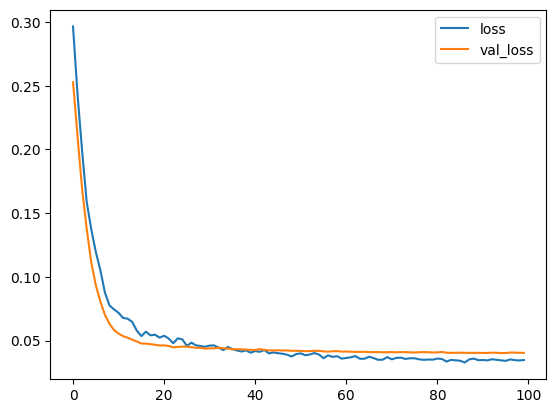

In [143]:
# avaliando o modelo
losses = pd.DataFrame(model.history.history)
losses.plot()

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


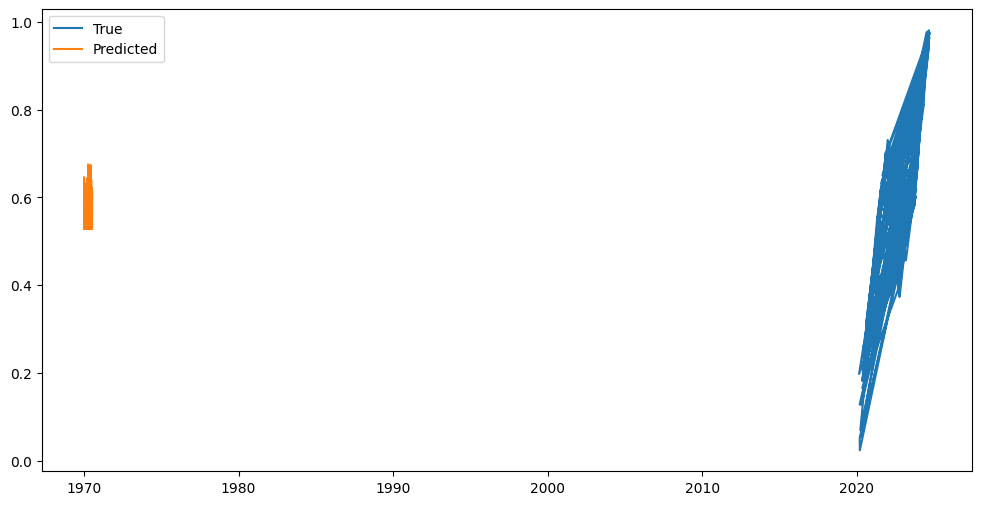

In [147]:
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)

plt.figure(figsize=(12, 6))
plt.plot(y_test, label='True')
plt.plot(predictions, label='Predicted')
plt.legend()
plt.show()